##### Copyright 2024 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 2D spatial understanding with Gemini 2.0

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb"><img src="https://github.com/google-gemini/cookbook/blob/main/images/colab_logo_32px.png?raw=1" />Run in Google Colab</a>
  </td>
</table>

This notebook introduces object detection and spatial understanding with the Gemini API like in the [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) from [AI Studio](https://aistudio.google.com) and demonstrated in the [Building with Gemini 2.0: Spatial understanding](https://www.youtube.com/watch?v=-XmoDzDMqj4) video.

You'll learn how to use Gemini the same way as in the demo and perform object detection like this:
<img src="https://storage.googleapis.com/generativeai-downloads/images/cupcakes_with_bbox.png" />

There are many examples, including object detection with

* simply overlaying information
* searching within an image
* translating and understanding things in multiple languages
* using Gemini thinking abilities

**Note**

There's no "magical prompt". Feel free to experiment with different ones. You can use the dropdown to see different samples, but you can also write your own prompts. Also, you can try uploading your own images.

----

## Setup

### Install SDK

The new **[Google Gen AI SDK](https://github.com/googleapis/python-genai)** provides programmatic access to Gemini 2.0 (and previous models) using both the [Google AI for Developers](https://ai.google.dev/gemini-api/docs/models/gemini-v2) and [Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview) APIs. With a few exceptions, code that runs on one platform will run on both. This means that you can prototype an application using the Developer API and then migrate the application to Vertex AI without rewriting your code.

More details about this new SDK on the [documentation](https://googleapis.github.io/python-genai/) or in the [Getting started](../quickstarts/Get_started.ipynb) notebook.

In [2]:
!pip install -U -q google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 4.8 MB/s eta 0:00:00


### Setup your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [3]:
from google.colab import userdata
import os

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with your API key.

In [4]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### Select and configure a model

Spatial understanding works best [Gemini 2.0 Flash model](https://ai.google.dev/gemini-api/docs/models/gemini-v2). You can try with the older ones but it might be more inconsistent (`gemini-1.5-flash-001` had the best results of the previous generation). The [Object detection](../examples/Object_detection.ipynb) contains good examples of what previous models were able to do.

For more information about all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini) for extended information on each of them.

In [5]:
model_name = "gemini-2.0-flash" # @param ["gemini-1.5-flash-latest","gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.0-pro-exp-02-05"] {"allow-input":true}

### System instructions

 With the new SDK, the `system_instructions` and the `model` parameters must be passed in all `generate_content` calls, so let's save them to not have to type them all the time.

In [6]:
bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
      """

In [7]:
safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

The system instructions are mainly used to make the prompts shorter by not having to reapeat each time the format. They are also telling the model how to deal with similar objects which is a nice way to let it be creative.

The [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) is using a different strategy with no system instructions but a longer prompt. You can see their full prompts by clicking on the "show raw prompt" button on the right. There no optimal solution, experiment with diffrent strategies and find the one that suits your use-case the best.

### Import

Import all the necessary modules.

In [8]:
import google.generativeai as genai
from PIL import Image

import io
import os
import requests
from io import BytesIO

### Utils

Some scripts will be needed to draw the bounding boxes. Of course they are just examples and you are free to just write your own.

For example the [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) from [AI Studio](https://aistudio.google.com) uses HML to render the bounding boxes. You can find its code in the [Github repo](https://github.com/google-gemini/starter-applets/tree/main/spatial).

In [9]:
# @title Plotting Util

# Get Noto JP font to display janapese characters
!apt-get install fonts-noto-cjk  # For Noto Sans CJK JP

#!apt-get install fonts-source-han-sans-jp # For Source Han Sans (Japanese)

import json
import random
import io
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json.loads(bounding_boxes)):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
      abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
      abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
      abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    img.show()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 4s (17.1 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [10]:
# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

### Get example images

In [11]:
# Load sample images
!wget https://storage.googleapis.com/generativeai-downloads/images/socks.jpg -O Socks.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/vegetables.jpg -O Vegetables.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/Japanese_Bento.png -O Japanese_bento.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/Cupcakes.jpg -O Cupcakes.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/origamis.jpg -O Origamis.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/fruits.jpg -O Fruits.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/cat.jpg -O Cat.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/pumpkins.jpg -O Pumpkins.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/breakfast.jpg -O Breakfast.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/bookshelf.jpg -O Bookshelf.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/spill.jpg -O Spill.jpg -q

## Overlaying Information

Let's start by loading an image, the origami one for example:

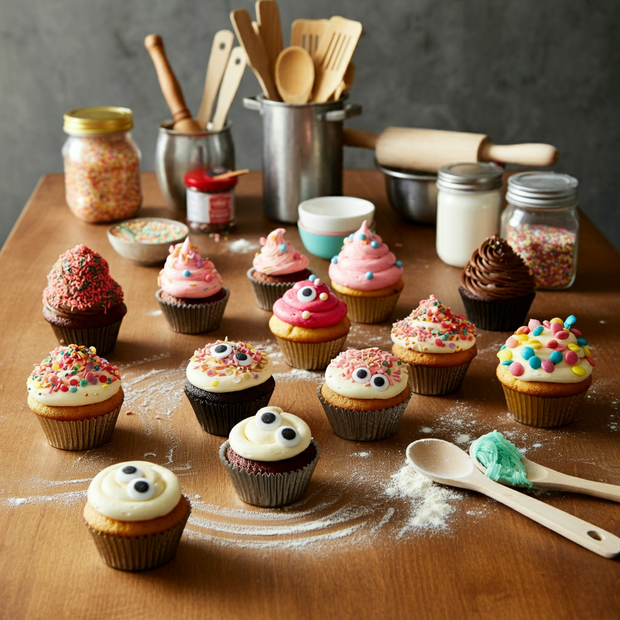

In [34]:
image = "Cupcakes.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}

im = Image.open(image)
im.thumbnail([620,620], Image.Resampling.LANCZOS)
im

Let's start with a simple prompt to find all items in the image.

To prevent the model from repeating itself, it is recommended to use a temperature over 0, in this case 0.5. Limiting the number of items (25 in the systemp instructions) is also a way to prevent the model from looping and to speed up the decoding of the bounding boxes. You can experiment with these parameters and find what works best for your use-case.

In [35]:
prompt = "Detect the 2d bounding boxes of the cupcakes (with “label” as topping description”)"  # @param {type:"string"}

# Load and resize image
im = Image.open(BytesIO(open(image, "rb").read()))
im.thumbnail([1024,1024], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Check output
print(response.text)

```json
[
  {"box_2d": [384, 65, 562, 203], "label": "red sprinkles"},
  {"box_2d": [376, 253, 539, 365], "label": "pink swirl"},
  {"box_2d": [351, 400, 495, 496], "label": "pink swirl"},
  {"box_2d": [359, 531, 524, 648], "label": "pink swirl with blue sprinkles"},
  {"box_2d": [375, 746, 535, 860], "label": "chocolate"},
  {"box_2d": [541, 40, 727, 200], "label": "sprinkles"},
  {"box_2d": [437, 434, 596, 562], "label": "pink"},
  {"box_2d": [453, 625, 637, 770], "label": "sprinkles"},
  {"box_2d": [451, 796, 687, 959], "label": "blue and yellow sprinkles"},
  {"box_2d": [541, 292, 698, 445], "label": "googly eyes"},
  {"box_2d": [546, 515, 713, 664], "label": "googly eyes"},
  {"box_2d": [644, 350, 818, 523], "label": "googly eyes"},
  {"box_2d": [742, 139, 923, 309], "label": "googly eyes"}
]
```


As you can see, even without any instructions about the format, Gemini is trained to always use this format with a label and the coordinates of the bounding box in a "box_2d" array.

Just be careful, the y coordinates are first, x ones afterwards contrary to common usage.

In [36]:
plot_bounding_boxes(im, response.text)
im

Output hidden; open in https://colab.research.google.com to view.

## Search within an image

Let's complicate things and search within the image for specific objects.

```json
[
  {"box_2d": [53, 248, 388, 527], "label": "sock with face"},
  {"box_2d": [236, 662, 653, 862], "label": "sock with face"}
]
```
(640, 482)


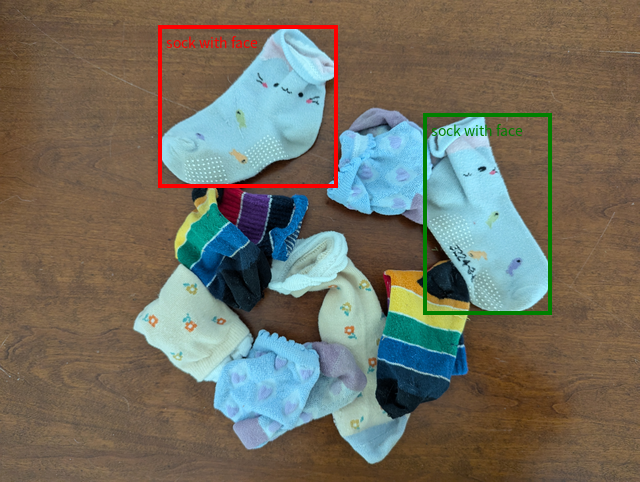

In [15]:
image = "Socks.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Show me the positions of the socks with the face"  # @param ["Detect all rainbow socks", "Find all socks and label them with emojis ", "Show me the positions of the socks with the face","Find the sock that goes with the one at the top"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Check output
print(response.text)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

Try it with different images and prompts. Different samples are proposed but you can also write your own.

## Multilinguality

As Gemini is able to understand multiple languages, you can combine spatial reasoning with multilingual capabilities.

You can give it an image like this and prompt it to label each item with Japanese characters and English translation. The model reads the text and recognize the pictures from the image itself and translates them.

(640, 640)


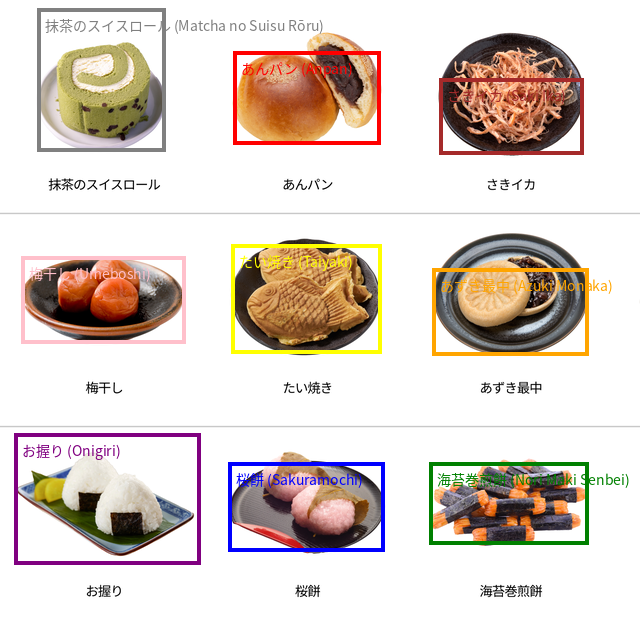

In [17]:
image = "Japanese_bento.png" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Detect food, label them with Japanese characters + english translation."  # @param ["Detect food, label them with Japanese characters + english translation.", "Show me the vegan dishes","Explain what those dishes are with a 5 words description","Find the dishes with allergens and label them accordingly"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

## Use Gemini reasoning capabilities

The model can also reason based on the image, you can ask it about the positions of items, their utility, or, like in this example, to find the shadow of a speficic item.

(640, 482)


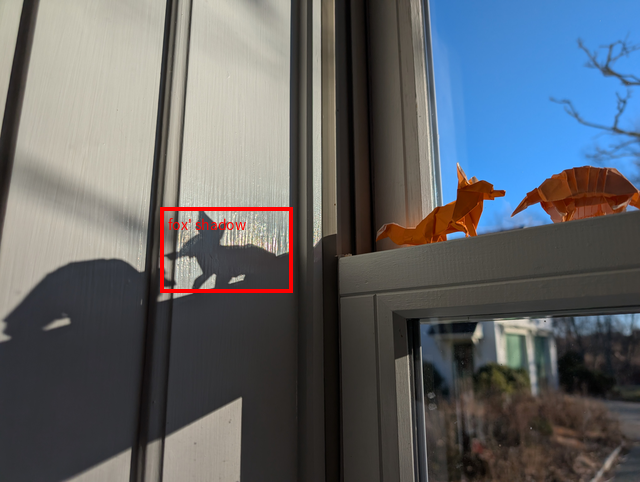

In [18]:
image = "Origamis.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Draw a square around the fox' shadow"  # @param ["Find the two origami animals.", "Where are the origamis' shadows?","Draw a square around the fox' shadow"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

You can also use Gemini knowledge to enhanced the labels returned. In this example Gemini will give you advices on how to fix your little mistake.

As you can see this time, you're only resizing the image to 1024px as it helps the model getting the bigger picture adn give you advices. There's no clear rule about when to do it, experiment and find what works the best for you.

(640, 480)


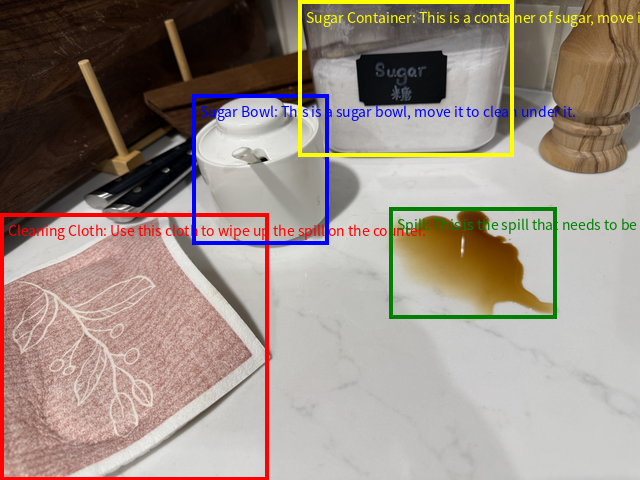

In [31]:
image = "Spill.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Tell me how to clean my table with an explanation as label. Do not just label the items"  # @param ["Show me where my coffee was spilled.", "Tell me how to clean my table with an explanation as label. Do not just label the items","Draw a square around the fox' shadow"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

In [29]:
response.text

'Here are the bounding box detections:\n```json\n[\n  {"box_2d": [447, 0, 1000, 418], "label": "pink cloth"},\n  {"box_2d": [197, 300, 510, 514], "label": "sugar bowl"},\n  {"box_2d": [433, 607, 664, 871], "label": "spill"},\n  {"box_2d": [0, 465, 325, 807], "label": "sugar container"}\n]\n```\nHere\'s how to clean the table:\n\n1.  **Grab the pink cloth**: Use the pink cloth to wipe up the spill.\n2.  **Wipe the spill**: Gently wipe the spill, starting from the outside and working your way inward to prevent spreading it further.\n3.  **Clean the area**: Once you\'ve removed the majority of the spill, use a clean, damp cloth or sponge with a mild dish soap to clean the affected area.\n4.  **Rinse**: Rinse the area with a clean, damp cloth to remove any soap residue.\n5.  **Dry**: Dry the surface thoroughly with a clean towel.\n'

And if you check the previous examples, the [Japanese food](#scrollTo=tvVSSr7z3uN4) one in particular,multiple other prompt samples are provided to experiment with Gemini reasoning capabilities.

## Preliminary capabilities: pointing and 3D boxes

Pointing and 3D bounding boxes are experimental model capabilities. Check this [other notebook](../examples/Spatial_understanding_3d.ipynb) to get a sneak peek on those upcoming capabilities.

<a href="../examples/Spatial_understanding_3d.ipynb"><img src="https://storage.googleapis.com/generativeai-downloads/images/box_3d.png" height="400"/></a>

## What's next?

For a more end-to-end example, the code from the [AI Studio Spatial understanding example](https://aistudio.google.com/starter-apps/spatial)  is available on [Github](https://github.com/google-gemini/starter-applets/tree/main/spatial).

You'll also find multiple other examples of Gemini 2.0 capabilities in the [Gemini 2.0 cookbook](https://github.com/google-gemini/cookbook/tree/main/gemini-2/), in particular the [Live API](./Get_started_LiveAPI.ipynb) and the [video understanding](./Video_understanding.ipynb) one.

Related to image recognition and reasoning, [Market a jet backpack](../examples/Market_a_Jet_Backpack.ipynb) and [Guess the shape](../examples/Guess_the_shape.ipynb) examples are worth checking to continue your Gemini API discovery (Note: these examples still use the old SDK). And of course the [pointing and 3d boxes](../examples/Spatial_understanding_3d.ipynb) example referenced earlier.